In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# load data

In [2]:
data = pd.read_csv('../data/proceed/non_encode_data.csv')
data.head()

C:\Users\Warin\AppData\Local\Temp\ipykernel_6020\149924035.py:1: DtypeWarning: Columns (2,4,8,20,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/proceed/non_encode_data.csv')


,accounting_date,company_code,customer_code,customer_district_code,item_code,business_area_code,item_group_code,item_class_code,item_type,bonus_group_code,...,line_number,invoice_date,customer_order_number,order_date,dss_update_time,day_gap,order_group,value_sales_log_plus1_transformed,value_cost_log_plus1_transformed,value_quantity_log_plus1_transformed
0,2012-05-09,101,411800601,410,GENIE8WWWBC,LMP,Other,LMP01,5,Trade,...,1,2012-05-09,2865354,2012-05-09,49:58.7,0,Normal Order,5.390897,5.188489,4.442651
1,2012-02-16,101,361000403,300,GENIE8WWWBC,LMP,Other,LMP01,5,Trade,...,1,2012-02-16,2833515,2012-02-16,49:58.7,0,Normal Order,3.670715,3.275513,2.564949
2,2012-05-09,101,361000403,300,GENIE8WWWBC,LMP,Other,LMP01,5,Trade,...,1,2012-05-09,2864857,2012-05-08,49:58.7,1,Normal Order,3.718438,3.275513,2.564949
3,2012-05-18,101,565540415,500,GENIE8WWWBC,LMP,Other,LMP01,5,Trade,...,1,2012-05-18,2869759,2012-05-18,49:58.7,0,Other,3.049273,2.619467,1.945910
4,2012-01-09,101,565540415,500,GENIE8WWWBC,LMP,Other,LMP01,5,Trade,...,1,2012-01-09,2819189,2012-01-09,49:58.7,0,Other,3.002708,2.619467,1.945910


# fix data type

In [3]:
data['order_date'] = pd.to_datetime(data['order_date']) #convert to datetime
data['customer_order_number'] = data['customer_order_number'].astype(str) #convert to string
data['customer_code'] = data['customer_code'].astype(str) #convert to string


# Create RFM metric

RFM (Recency, Frequency, Monetary) analysis is a marketing technique used to segment customers based on their purchasing behaviors. It helps businesses identify their most valuable customers and tailor their marketing strategies accordingly. Here’s a breakdown of each component:

**Recency** (R): Measures how recently a customer made a purchase. Customers who purchased more recently are generally more likely to return, as recent activity often indicates stronger engagement.

**Frequency** (F): Measures how often a customer makes a purchase. High-frequency customers are typically more loyal and engaged. Frequency helps businesses understand customer loyalty and predict the likelihood of repeat purchases.

**Monetary** (M): Measures the amount of money a customer spends. Customers with higher monetary values contribute more to the company’s revenue, making them more valuable.

Each component is scored, often on a scale (e.g., 1-5), and combined to create an RFM score for each customer. For instance:

High R, High F, High M: These customers are the most valuable—they shop often, have shopped recently, and spend a lot. They're prime targets for loyalty programs or exclusive offers.
High R, Low F, Low M: These customers recently made a small or infrequent purchase. They might be encouraged to make a second purchase with tailored promotions.
Low R, High F, High M: These customers are big spenders but haven't purchased recently, so a win-back campaign could be effective.

In [4]:
data = data[data['value_sales'] > 0] #remove negative sales

remove nagative sales because we want to focus on gross sales rather than net sales

In [5]:
# Reference date for calculating recency
reference_date = pd.to_datetime('2013-12-31')

# Group by customer_code to calculate RFM metrics
rfm = data.groupby('customer_code').agg({
    'order_date': lambda x: (reference_date - x.max()).days,  # Recency
    'customer_order_number': 'nunique',  # Frequency
    'value_sales': 'sum'  # Monetary
})

# Rename columns for clarity
rfm.columns = ['recency', 'frequency', 'monetary']

# Display the RFM table
rfm = rfm.reset_index()
rfm.round(2)


,customer_code,recency,frequency,monetary
0,100050100,12,30,4835922.58
1,100210100,40,22,73415.70
2,100230100,266,4,37190.92
3,100250200,40,4,13273.45
4,100270100,42,22,91784.41
...,...,...,...,...
4416,ZI9000101,22,157,307456.52
4417,ZI9000102,28,237,1172088.92
4418,ZI9000103,340,1,658.66
4419,ZI9500101,382,1,212.11


recency metric was calculated by refference date - max(order_date)
refference date is the date that we are interest such as the end of years or the end of month, or the end of quarter

frequency metric was calculated by count unique customer_order_number

Monetary metric was calculated by sum value_sales

In [6]:
# Assign scores using quantiles
rfm['recency_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine the scores to create a composite RFM score
rfm['RFM_score'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str) + rfm['monetary_score'].astype(str)

# Display the scored RFM table
rfm[['customer_code', 'recency', 'frequency', 'monetary', 'recency_score', 'frequency_score', 'monetary_score', 'RFM_score']]


,customer_code,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score
0,100050100,12,30,4.835923e+06,5,3,5,535
1,100210100,40,22,7.341570e+04,3,3,4,334
2,100230100,266,4,3.719092e+04,1,1,3,113
3,100250200,40,4,1.327345e+04,3,1,3,313
4,100270100,42,22,9.178441e+04,3,3,4,334
...,...,...,...,...,...,...,...,...
4416,ZI9000101,22,157,3.074565e+05,3,4,5,345
4417,ZI9000102,28,237,1.172089e+06,3,5,5,355
4418,ZI9000103,340,1,6.586650e+02,1,1,1,111
4419,ZI9500101,382,1,2.121120e+02,1,1,1,111


In [7]:
def segment_customer(rfm_score):
    if rfm_score == '555':  # Best customers
        return 'Champion'
    elif rfm_score.startswith('5'): # High spenders
        return 'Loyal Customer'
    elif rfm_score[1] == '5': # Frequent buyers
        return 'Frequent Buyer'
    elif rfm_score[0] == '1': # Lost customers
        return 'At Risk'
    else:
        return 'Others'

# Apply segmentation
rfm['segment'] = rfm['RFM_score'].apply(segment_customer)

# Display the segmented RFM table
rfm[['customer_code', 'recency', 'frequency', 'monetary', 'RFM_score', 'segment']]


,customer_code,recency,frequency,monetary,RFM_score,segment
0,100050100,12,30,4.835923e+06,535,Loyal Customer
1,100210100,40,22,7.341570e+04,334,Others
2,100230100,266,4,3.719092e+04,113,At Risk
3,100250200,40,4,1.327345e+04,313,Others
4,100270100,42,22,9.178441e+04,334,Others
...,...,...,...,...,...,...
4416,ZI9000101,22,157,3.074565e+05,345,Others
4417,ZI9000102,28,237,1.172089e+06,355,Frequent Buyer
4418,ZI9000103,340,1,6.586650e+02,111,At Risk
4419,ZI9500101,382,1,2.121120e+02,111,At Risk


In [8]:
# change the data type of the columns
rfm['recency_score'] = rfm['recency_score'].astype(int)
rfm['frequency_score'] = rfm['frequency_score'].astype(int)
rfm['monetary_score'] = rfm['monetary_score'].astype(int)

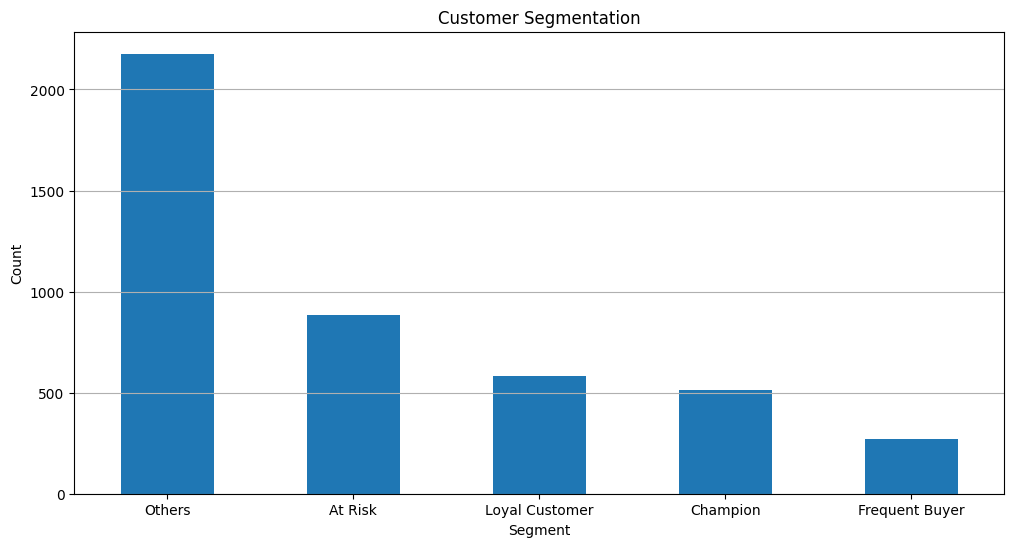

In [9]:
rfm['segment'].value_counts().plot(kind='bar', figsize=(12, 6))
plt.title('Customer Segmentation')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
#save the plot
plt.savefig('../reports/figures/segmentation.png')

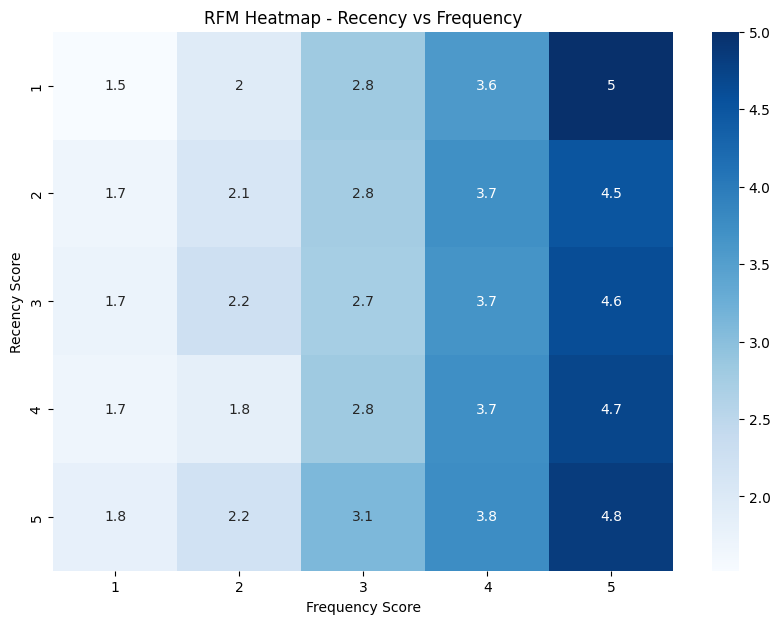

In [10]:
# Pivot table for Recency vs Frequency
rf_matrix = rfm.pivot_table(index='recency_score', columns='frequency_score', values='monetary_score', aggfunc='mean')

# Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(rf_matrix, annot=True, cmap='Blues')
plt.title('RFM Heatmap - Recency vs Frequency')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
#save the plot
plt.savefig('../reports/figures/heatmap.png')
plt.show()

1. High Recency and Frequency (Bottom Right of the Heatmap):

 - The values are higher in the bottom right, where both recency and frequency scores are high. This indicates that customers who purchased more recently and more frequently tend to have higher monetary value. These segments are likely your "best customers" and deserve focused marketing efforts.
2. Low Recency and High Frequency (Top Right):

- Customers with high frequency but low recency tend to still show higher monetary values. It may suggest that even if they haven't made a recent purchase, they have a history of frequent and high-value purchases. Consider targeted campaigns to re-engage this group.
3. High Recency and Low Frequency (Bottom Left):

- The lighter cells in this region show that customers who have purchased recently but infrequently have relatively lower monetary values. These customers could be new or need some incentive to make more frequent purchases.
4. Balanced Segments (Middle):

- The middle cells indicate segments with average scores. Their monetary values vary, so they might need more targeted campaigns based on additional factors beyond just RFM scores.

In [20]:
rfm_count = rfm.groupby('segment').size().reset_index(name='count')
rfm_count

,segment,count
0,At Risk,883
1,Champion,512
2,Frequent Buyer,269
3,Loyal Customer,580
4,Others,2177


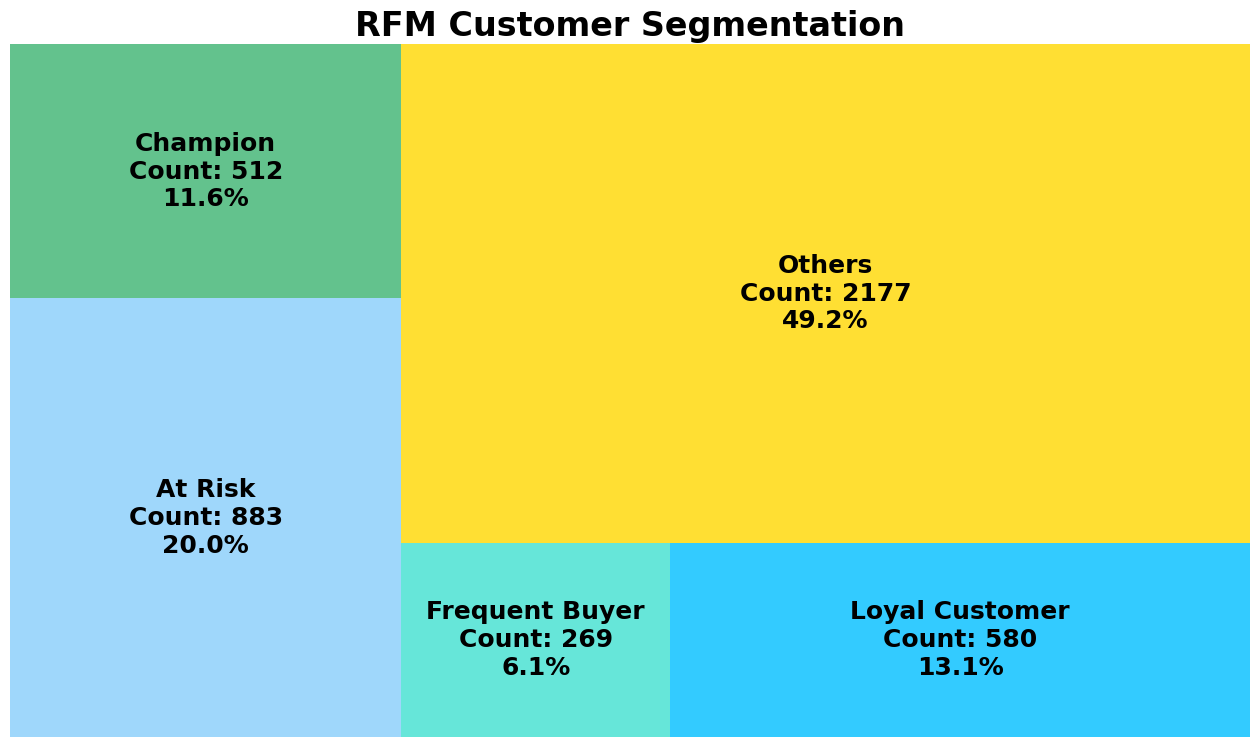

In [27]:
import squarify
# Calculate percentage for each segment
rfm_count['Percentage'] = (rfm_count['count'] / rfm_count['count'].sum()) * 100
rfm_count['Label'] = rfm_count['segment'] + "\nCount: " + rfm_count['count'].astype(str) + "\n" + rfm_count['Percentage'].round(1).astype(str) + '%'

# Define color palette to match the shared image
colors = ['#87CEFA', '#3CB371', '#40E0D0', '#00BFFF', '#FFD700']

# Plot Treemap
plt.figure(figsize=(16, 9))
squarify.plot(
    sizes=rfm_count['count'], 
    label=rfm_count['Label'], 
    color=colors, 
    alpha=0.8,
    text_kwargs={'fontsize': 18, 'weight': 'bold', 'color': 'black'}
)

plt.axis('off')
plt.title("RFM Customer Segmentation", fontsize=24, weight='bold')
#save the plot
plt.savefig('../reports/figures/treemap.png')
plt.show()

# Quartile RFM

In [11]:
data['quarter'] = data['order_date'].dt.to_period("Q")
data['quarter']

0          2012Q2
1          2012Q1
2          2012Q2
3          2012Q2
4          2012Q1
            ...  
1971495    2013Q4
1971496    2013Q2
1971497    2013Q4
1971498    2013Q4
1971499    2013Q3
Name: quarter, Length: 1849971, dtype: period[Q-DEC]

In [12]:
# Reference date (for each quarter, you may update accordingly for your needs)
data['quarter_end_date'] = data['quarter'].dt.end_time
data['quarter_end_date'] = pd.to_datetime(data['quarter_end_date'].dt.date)
data['order_date'] = pd.to_datetime(data['order_date'])
data['quarter_end_date'] = pd.to_datetime(data['quarter_end_date'])
# Group by customer and quarter to calculate RFM metrics
quarterly_rfm = data.groupby(['customer_code', 'quarter', 'quarter_end_date']).agg({
    'order_date': lambda x: (data.loc[x.index, 'quarter_end_date'].iloc[0] - x.max()).days,  # Recency
    'customer_order_number': 'nunique',  # Frequency
    'value_sales': 'sum'  # Monetary
})

# Rename columns
quarterly_rfm.columns = ['recency', 'frequency', 'monetary']

# Display the quarterly RFM table
quarterly_rfm = quarterly_rfm.reset_index()
quarterly_rfm.round(2)


,customer_code,quarter,quarter_end_date,recency,frequency,monetary
0,100050100,2013Q2,2013-06-30,3,12,3947816.08
1,100050100,2013Q3,2013-09-30,8,8,606204.00
2,100050100,2013Q4,2013-12-31,12,10,281902.50
3,100210100,2012Q1,2012-03-31,18,3,5555.12
4,100210100,2012Q2,2012-06-30,25,4,7347.79
...,...,...,...,...,...,...
26073,ZI9000102,2013Q3,2013-09-30,0,28,188963.78
26074,ZI9000102,2013Q4,2013-12-31,28,22,30793.17
26075,ZI9000103,2013Q1,2013-03-31,65,1,658.66
26076,ZI9500101,2012Q4,2012-12-31,17,1,212.11


In [13]:
# Assign scores using quantiles
quarterly_rfm['recency_score'] = pd.qcut(quarterly_rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
quarterly_rfm['frequency_score'] = pd.qcut(quarterly_rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
quarterly_rfm['monetary_score'] = pd.qcut(quarterly_rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine the scores to create a composite RFM score
quarterly_rfm['RFM_score'] = quarterly_rfm['recency_score'].astype(str) + quarterly_rfm['frequency_score'].astype(str) + quarterly_rfm['monetary_score'].astype(str)

# Display the scored RFM table
quarterly_rfm


,customer_code,quarter,quarter_end_date,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score
0,100050100,2013Q2,2013-06-30,3,12,3.947816e+06,5,3,5,535
1,100050100,2013Q3,2013-09-30,8,8,6.062040e+05,4,3,5,435
2,100050100,2013Q4,2013-12-31,12,10,2.819025e+05,3,3,5,335
3,100210100,2012Q1,2012-03-31,18,3,5.555120e+03,2,2,3,223
4,100210100,2012Q2,2012-06-30,25,4,7.347790e+03,2,2,3,223
...,...,...,...,...,...,...,...,...,...,...
26073,ZI9000102,2013Q3,2013-09-30,0,28,1.889638e+05,5,4,5,545
26074,ZI9000102,2013Q4,2013-12-31,28,22,3.079317e+04,1,4,5,145
26075,ZI9000103,2013Q1,2013-03-31,65,1,6.586650e+02,1,1,1,111
26076,ZI9500101,2012Q4,2012-12-31,17,1,2.121120e+02,2,1,1,211


In [14]:
quarterly_rfm = quarterly_rfm[quarterly_rfm['quarter_end_date'] >= '2012-01-01']

In [15]:
# Apply segmentation
quarterly_rfm['segment'] = quarterly_rfm['RFM_score'].apply(segment_customer)

C:\Users\Warin\AppData\Local\Temp\ipykernel_6020\289015957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quarterly_rfm['segment'] = quarterly_rfm['RFM_score'].apply(segment_customer)


In [16]:
quarterly_rfm['monetary_score'] = quarterly_rfm['monetary_score'].astype(int)
quarterly_rfm['frequency_score'] = quarterly_rfm['frequency_score'].astype(int)
quarterly_rfm['recency_score'] = quarterly_rfm['recency_score'].astype(int)

C:\Users\Warin\AppData\Local\Temp\ipykernel_6020\1515845584.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quarterly_rfm['monetary_score'] = quarterly_rfm['monetary_score'].astype(int)
C:\Users\Warin\AppData\Local\Temp\ipykernel_6020\1515845584.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quarterly_rfm['frequency_score'] = quarterly_rfm['frequency_score'].astype(int)
C:\Users\Warin\AppData\Local\Temp\ipykernel_6020\1515845584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy o

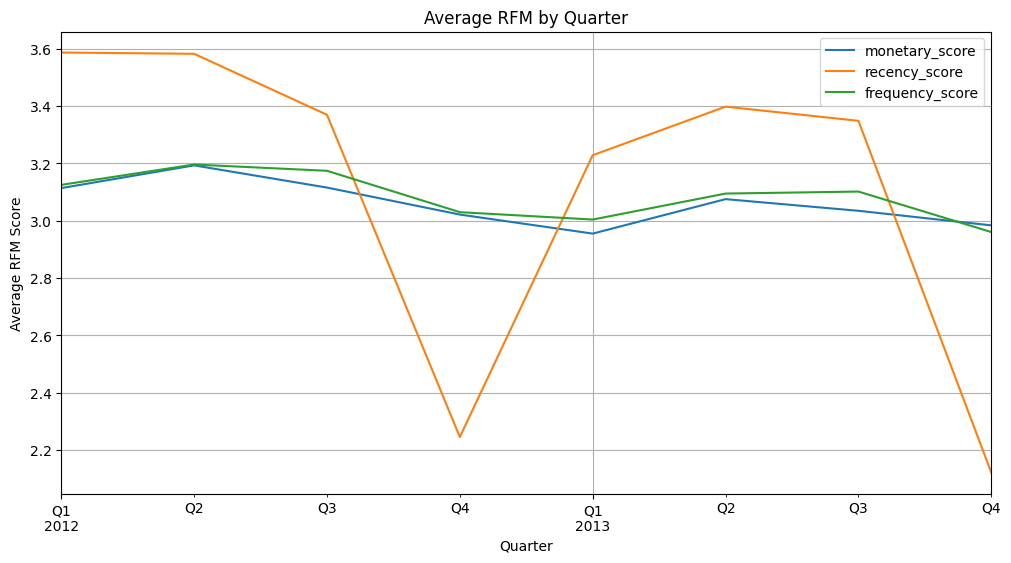

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pandas as pd

#plot line chart for average monetary value
plt.figure(figsize=(12, 6))
quarterly_rfm.groupby('quarter_end_date')['monetary_score'].mean().plot(kind='line')
quarterly_rfm.groupby('quarter_end_date')['recency_score'].mean().plot(kind='line')
quarterly_rfm.groupby('quarter_end_date')['frequency_score'].mean().plot(kind='line')
plt.title('Average RFM by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average RFM Score')
plt.xticks(rotation=0)
plt.grid(True)
plt.legend()
#save the plot
plt.savefig('../reports/figures/average_rfm_by_quarter.png')
plt.show()

Summary: The data indicates stable but slightly declining monetary and frequency metrics, while the recency score shows seasonal fluctuations with a sharp end-of-year decline. These insights point to potential areas for improvement, such as engaging customers during low-recency periods and encouraging more frequent purchases.

In [18]:
#count the number of customers in each segment quarterly
segment_counts = quarterly_rfm.groupby(['quarter', 'segment']).size().unstack().fillna(0)
segment_counts = segment_counts.div(segment_counts.sum(axis=1), axis=0).round(2)
segment_counts

segment,At Risk,Champion,Frequent Buyer,Loyal Customer,Others
quarter,,,,,
2012Q1,0.16,0.14,0.02,0.29,0.39
2012Q2,0.16,0.17,0.02,0.27,0.38
2012Q3,0.19,0.14,0.05,0.19,0.43
2012Q4,0.24,0.00,0.19,0.00,0.56
2013Q1,0.18,0.09,0.07,0.12,0.54
2013Q2,0.17,0.14,0.05,0.17,0.47
2013Q3,0.18,0.11,0.07,0.18,0.46
2013Q4,0.26,0.00,0.17,0.00,0.56


<Figure size 1200x600 with 0 Axes>

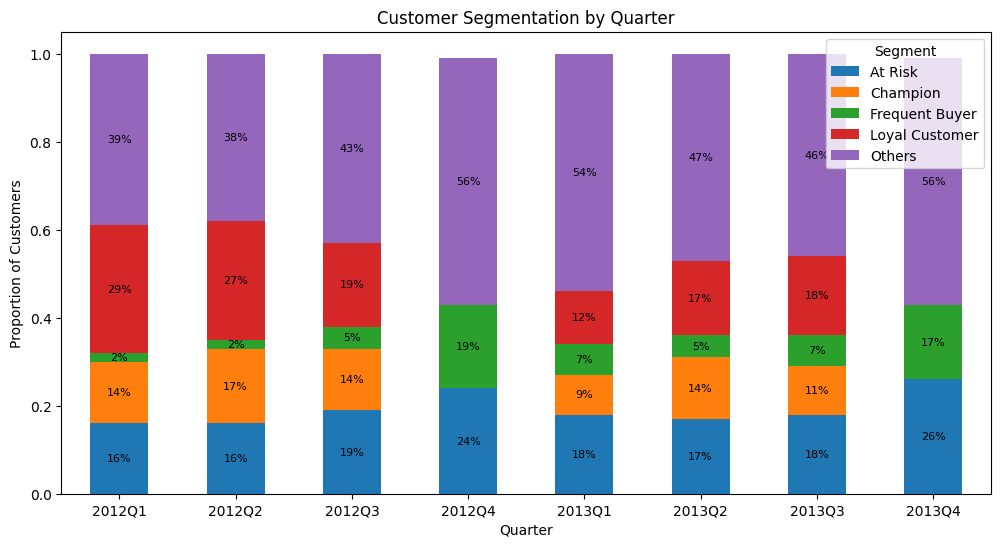

In [19]:
#plot the stacked bar chart
plt.figure(figsize=(12, 6))
segment_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Customer Segmentation by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Proportion of Customers')
plt.xticks(rotation=0)
plt.legend(title='Segment')
#show values on each bar
# Displaying values on each segment of the bar
for c in plt.gca().containers:
    # Add labels to each segment in the stack
    labels = [f"{v.get_height() * 100:.0f}%" if v.get_height() > 0.01 else '' for v in c]  # Only show if > 5%
    plt.gca().bar_label(c, labels=labels, label_type='center', fontsize=8)
#save the plot
plt.savefig('../reports/figures/customer_segmentation_by_quarter.png')
plt.show()

In summary, the data reveals trends that could benefit from targeted interventions. For example, focusing on converting "Others" and "At Risk" customers into more loyal segments could improve retention and engagement, while the fluctuations in more loyal segments like "Champion" and "Frequent Buyer" might highlight areas to stabilize customer relationships.

# Summary

This Jupyter Notebook performs an RFM (Recency, Frequency, Monetary) analysis on customer data to segment customers based on their purchasing behaviors. The analysis includes the following steps:

1. **Data Loading and Preparation**:
    - The dataset is loaded and initial data types are fixed.
    - Negative sales values are removed to focus on gross sales.

2. **RFM Metric Calculation**:
    - Recency is calculated as the number of days since the last purchase.
    - Frequency is calculated as the number of unique orders.
    - Monetary is calculated as the total sales value.

3. **RFM Scoring**:
    - Scores for recency, frequency, and monetary are assigned using quantiles.
    - A composite RFM score is created by combining the individual scores.

4. **Customer Segmentation**:
    - Customers are segmented based on their RFM scores into categories such as Champion, Loyal Customer, Frequent Buyer, At Risk, and Others.

5. **Visualization**:
    - The distribution of customer segments is visualized using bar charts.
    - Trends in average RFM scores by quarter are plotted to identify patterns over time.

6. **Insights**:
    - The data reveals trends such as stable but slightly declining monetary and frequency metrics, and seasonal fluctuations in recency scores.
    - Targeted interventions can be designed to improve customer retention and engagement, especially for segments like "At Risk" and "Others".

The analysis provides valuable insights into customer behavior, helping businesses tailor their marketing strategies to different customer segments.